# AlexNet-Pytorch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optimizer
from torchvision import transforms
from torch.autograd import Variable

from LoadDataset import *
import matplotlib.pyplot as plt

现在我们使用Pytorch来搭建AlexNet,但是不幸的是在同样的超级参数下,Pytorch的AlexNet效果并没有Keras和Tensorflow优秀.下面我们来看看如何使用Pytorch搭建.

在Pytorch官网中能够直接找到[AlexNet](https://pytorch.org/docs/stable/_modules/torchvision/models/alexnet.html#alexnet):

<img src="../../../../../picture/211.png" height=500 width= 500>

从官方给出的模型可以看出,Pytorch的AlexNet并没有按照paper建立网络,下面我们仿照官方的例子创建模型.

### 1. Build AlexNet

下面我们来构建AlexNet模型,整体的框架如下显示:

![](../../../../../picture/182.png)

同样,由于我们的数据集```CatsVsDogs```是一个二分类,我们会在AleNet的基础上再加上一层```FC8==> (1000,1)```,以防神经元跨度过大.

另外我们与官方一样使用```nn.Sequential```构建模型.

在Pytorch中可以使用[torch.nn.LocalResponseNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.LocalResponseNorm)进行LRN.

处理公式如下:

<img src="../../../../../picture/213.png" height=300 width= 300>

In [2]:
class Forward(nn.Module):

    def __init__(self, rate):
        torch.manual_seed(123)
        nn.Module.__init__(self)
        
        self.CONV = nn.Sequential(
            # CONV1
            self.CONV2D(3, 96, kernel_size=(11, 11), stride=(4, 4)),
            nn.ReLU(inplace=True),
            self.MAXPOOL(kernel_size=(3, 3), stride=(2, 2)),
            self.LRN(size=5),
            # CONV2
            self.CONV2D(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=2),
            nn.ReLU(inplace=True),
            self.MAXPOOL(kernel_size=(3, 3), stride=(2, 2)),
            self.LRN(size=5),
            # CONV3
            self.CONV2D(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(inplace=True),
            # CONV4
            self.CONV2D(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(inplace=True),
            # CONV5
            self.CONV2D(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(inplace=True),
            self.MAXPOOL(kernel_size=(3, 3), stride=(2, 2)),
        )

        self.FULLY = nn.Sequential(
            # FC6
            self.FC(6 * 6 * 256, 4096),
            nn.ReLU(inplace=True),
            self.DROPOUT(rate=rate),
            # FC7
            self.FC(4096, 4096),
            nn.ReLU(inplace=True),
            self.DROPOUT(rate=rate),
            # FC8
            self.FC(4096, 1000),
            nn.ReLU(inplace=True),
            self.DROPOUT(rate=rate),

            # output
            self.FC(1000, 1),
            nn.Sigmoid()
        )

    def CONV2D(self, in_channels, out_channels, kernel_size, stride, padding=0):
        """
        Conv2d layer,accept shape (batch,C x H x W).
        Argus:
        -----
            in_channels (int): input channels.
            out_channels (int): output channels.
            kernel_size (int or tuple): kernel size, if is int, then k_h = k_w.
            stride (int or tuple): kernel stride, if is int ,then  s_h=s_w.
            padding (int or tuple): padding width,if is int,then p_h=p_w
        Return:
        -------
            conv2d: conv layer.
        """
        conv2d = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=kernel_size, stride=stride, padding=padding)
        
        # change weight initialization.
        nn.init.xavier_normal_(conv2d.weight)

        return conv2d

    def MAXPOOL(self, kernel_size, stride):
        """
        MaxPool layer,accept shape (batch,C x H x W).
        Argus:
        -----
            kernel_size (int or tuple): kernel size, if is int, then k_h = k_w.
            stride (int or tuple): kernel stride, if is int ,then  s_h=s_w.
        Return:
        ------
            maxpool: max pool layer.
        
        Note:
        -----
            In AleNet, the maxpool padding =0.
        """
        maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=0)
        return maxpool

    def LRN(self, size, alpha=1e-4, beta=0.75, k=1):
        """
        Local Response Normal,accept shape (batch,C x H x W).
        Argus:
        -----
            size: amount of neighbouring channels used for normalization
            alpha:multiplicative factor. Default: 0.0001
            beta:exponent. Default: 0.75
            k:additive factor. Default: 1
        Return:
        ------
            lrn: lrn layer.
        """
        lrn = nn.LocalResponseNorm(size=size, alpha=alpha, beta=beta, k=k)
        return lrn

    def FC(self, in_features, out_features):
        """
        fully connect,accepct shape (batch,...).
        
        Argus:
        -----
            in_features: input features.
            out_features: output features.
        
        Return:
        ------
            fc layer.
        """
        fc = nn.Linear(in_features=in_features, out_features=out_features)
        # change weight initialization.
        nn.init.xavier_normal_(fc.weight)
        return fc

    def DROPOUT(self, rate):
        """
        Dropout layer,accepct shape (batch,...).
        
        Argu:
        ----
            rate: probability of an element to be zeroed. Default: 0.5.
        
        Return:
        ------
            dropout: dropout layer.
        """
        dropout = nn.Dropout(p=rate)
        return dropout

    def forward(self, data):
        """
        forward propagation.
        
        Argus:
        -----
            data: training data set, the shape is (batch,C x H x W).
        """
        data = self.CONV(data)

        data = data.view(data.size(0), 256 * 6 * 6)

        data = self.FULLY(data)

        return data

现在我们来尝试一下Forward,看看能否输出正确维度.随机生成10个样本,每个样本的维度为$(3,227,227)$.

In [3]:
data = torch.rand(10,3,227,227)
model = Forward(0.5)
out = model.forward(data)
print('The Out shape is :{}'.format(out.size()))

The Out shape is :torch.Size([10, 1])


可以看到维度是正确的,下面我们可以开始构建启动函数.

### 2. Score

在构建启动函数之前,我们需要先构建评分函数```Score```.

该函数接受以下参数:

1.model: Sequential 模型.

2.cost: AlexNet模型的损失函数.

3.loader: 加载样本的DataLoader.

4.epoch: 当前的迭代次数

5.epochs: 总迭代次数.

6.type_data: 评分数据的类型(train/test)

7.device: 训练的device,可能是CPU也可能是CUDA.

该函数返回:

1.average_loss: 平均损失,指的是loader所有批次评分完毕后的平均值.

2.average_accuracy: 平均正确率,指的是loader所有批次评分完毕后的平均值.

需要注意的是,由于我们的模型中含有```Dropout layer```,所以在评分的时候我们一定要将模型更改为```model.eval()```模式,实际上在```BatchNorm```的时候也是要如此.详细查看[model.eval()](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.eval)

In [4]:
def Score(model, cost, loader, epoch, epochs, type_data,device):
    """
    Score func.
    
    Argus:
    -----
        model (class): alexnet model.
        cost (class):alexnet cost.
        loader (class): train/test DataLoader.
        epoch (int): currect iterate number.
        epochs (int): total ierate number.
        type_data (str): train or test.
        device : cpu or gpu(cuda).
    
    Return:
    -------
        
    """
    model.eval()
    average_accuracy = 0
    average_loss = 0
    N = 0
    NN = 0
    with torch.no_grad():
        for img, label in loader:

            label = label.float().to(device)
            out = model.forward(img.to(device))
            loss = cost(out, label)
            predict = torch.round(out)
            equal_ = torch.eq(predict, label).float()
            accuracy = torch.mean(equal_).item()
            average_accuracy += accuracy
            average_loss += loss
            N += 1
            NN += img.size()[0]
            print('[{}/{}] scoring {} ==> {} loss:{} acc:{}\r'.format(epoch + 1, epochs, type_data, NN,loss
                                                                      ,accuracy), end='', flush=True)

        average_accuracy /= N
        average_loss /= N
        print()
        print('[{}/{}] {} average loss: {:.4f}, average accuracy: {:.4f}'.format(epoch + 1, epochs, type_data,
                                                                 average_loss, average_accuracy))

        return average_loss, average_accuracy

### 3. Build AlexNet Model

现在我们可以开始构建AlexNet Model.

函数```AlexMoel```接受一下参数:

1.file_dir: 加载图片的目录,比如"../train".

2.lr: 学习率.

3.epochs: 迭代次数.

4.Load_samples: 加载的总样本数.

5.test_rate: 测试样本率.

6.drop_rate: dropout layer 的参数,以概率drop_rate将权重设置为0.

7.batch_size: 训练批次的大小.

8.kwargs: 其中包括可选参数:plt_path,用于保存loss/acc的图片路径;model_save_path:保存AlexNet 模型的路径.


In [5]:
def AlexMoel(file_dir, lr, epochs, Load_samples=None, test_rate=0.3, drop_rate=0.3, batch_size=100, **kwargs):
    
    # cache train/test loss and accuracy.
    train_loss_list = []
    test_loss_list = []

    train_acc_list = []
    test_acc_list = []
    
    # choose device : cpu or cuda.
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # split data set==> training data/ testing data.
    split_data = SplitData(file_dir, Load_samples=Load_samples, test_rate=test_rate, Shuffle=True)
    train_files, test_files, train_samples, test_samples = split_data()

    print('Using {}, Train Samples:{} Test Samples:{}'.format(str(device), train_samples, test_samples))

    load_train = Load(train_files, transform=ToTensor())
    train_loader = DataLoader(load_train, batch_size=batch_size, shuffle=True, num_workers=2)

    load_test = Load(test_files, transform=ToTensor())
    test_loader = DataLoader(load_test, batch_size=batch_size, shuffle=True, num_workers=2)
    
    # build model.
    model = Forward(drop_rate)
    if str(device) == 'cuda:0':
        model.cuda(device)
        
    # build loss function
    cost = nn.BCELoss()
    # build optimizer.
    optim = optimizer.RMSprop(model.parameters(), lr=lr, alpha=0.9)
    
    # start training...
    for epoch in range(epochs):
        # set model is train mode. !!
        model.train()
        NN = 0
        for img, label in train_loader:
            NN += img.size()[0]
            print('[{}/{}] train ==> [{}/{}] \r'.format(epoch+1,epochs,NN,train_samples),end='',flush=True)
            img = Variable(img).to(device)
            label = Variable(label).float().to(device)

            out = model.forward(img)
            loss = cost(out, label)
            optim.zero_grad()
            loss.backward()
            optim.step()
        # score in each epoch ==> train/test.
        train_loss, train_acc = Score(model, cost, train_loader, epoch, epochs, 'Train',device)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss, test_acc = Score(model, cost, test_loader, epoch, epochs, 'Test',device)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)
    
    # get save path, if have it.
    plt_path = kwargs.get('plt_path', None)
    model_save_path = kwargs.get('model_save_path', None)
    
    # saveing loss/acc picture or model.
    if plt_path:
        print('Starting Plot Loss/Accuracy...')
        Plot_loss_acc((train_loss_list, test_loss_list), (train_acc_list, test_acc_list), lr, plt_path)
        print('PLot Finished --> {}'.format(plt_path))
    if model_save_path:
        print('Starting Save Model...')
        torch.save(model.state_dict(), model_save_path)
        print('Save Finished --> {}'.format(model_save_path))

我们可以使用一下形式在google cloud 上进行训练,最后将保存的AlexNet_pytorch.pt/loss_acc.png download 到本地.

In [ ]:
file_dir = '/Users/huwang/Joker/Data_Set/catVSdot/train'
AlexMoel(file_dir, lr=1e-4, epochs=13, Load_samples=None,
             test_rate=0.3, drop_rate=0.5, batch_size=100,
             plt_path='loss_acc.png',
             model_save_path='AlexNet_pytorch.pt')

不幸的是,在同样的超级参数下,Pytorch生成的AlexNet模型效果没有Keras和Tensorflow优秀,平均正确率一直徘徊在0.6-0.7左右.以下是模型训练过程中截取的部分,更多loss/acc请查看[loss_acc](loss_acc.txt).

```
[12/13] scoring Train ==> 17500 loss:0.5949438810348511 acc:0.69999998807907168
[12/13] Train average loss: 0.5553, average accuracy: 0.7017
[12/13] scoring Test ==> 7500 loss:0.6081874370574951 acc:0.6899999976158142
[12/13] Test average loss: 0.6149, average accuracy: 0.6520
[13/13] scoring Train ==> 17500 loss:0.6191587448120117 acc:0.6100000143051147
[13/13] Train average loss: 0.5884, average accuracy: 0.6797
[13/13] scoring Test ==> 7500 loss:0.5791038870811462 acc:0.6599999666213989
[13/13] Test average loss: 0.6509, average accuracy: 0.6313```

损失和正确率的图像如下显示:

![](loss_acc.png)

可以看到实际上在第8个epoch的时候模型开始逐渐过拟合.

为了证明,我还测试了Pytorch官方AlexNet模型的运行结果,两者结果相差不大.

![](../../../../../picture/212.png)

可能Pytorch的AlexNet模型需要更多次迭代,亦或许需要将Input进行更多的特征工程处理,包括各个参数的调优,这里为了横向比较三个框架,就不再进行更多的测试了.

**Ps:**

也许是我使用Pytorch的方法不正确,无论是正确率还是训练时间长度,Pytorch都比Tensorflow和Keras效率低.如果各位大佬发现代码有任何问题欢迎Issues或者联系邮箱:jokermonster030@gmail.com,感谢.

### 4. Testing Model.

现在我们来加载已经训练完毕的模型并尝试测试.

更多关于模型加载与保存请查看[saving_loading_models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

#### 4.1 Crop


我们知道AlexNet模型在测试阶段,输入一张$(256\times 256)$的图片,截取四个角以及中心后得到5张图片并将其水平翻转得到10张图片,最后取概率最大类.

那么我们可以直接使用Pytorch中[transforms.FiveCrop](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.FiveCrop)可以直接获取四个角以及中心5张图片,其返回一个tuple,并且tuple中是PIL对象,这意味着我们可以使用PIL中的方法.

**FiveCrop**

In [6]:
file_path = 'dog.jpg'
five_crop = transforms.FiveCrop((224,224))

image = Image.open(file_path)
image = image.resize((256,256))

Five_image = five_crop(image) # return PIL type

print('The FiveCrop Result:\n',Five_image)

The FiveCrop Result:
 (<PIL.Image.Image image mode=RGB size=224x224 at 0x10EF26DA0>, <PIL.Image.Image image mode=RGB size=224x224 at 0x10EF2FDD8>, <PIL.Image.Image image mode=RGB size=224x224 at 0x11CF57588>, <PIL.Image.Image image mode=RGB size=224x224 at 0x10F0582B0>, <PIL.Image.Image image mode=RGB size=224x224 at 0x10F058320>)


我们可以随意查看其中一张,比如左上角.

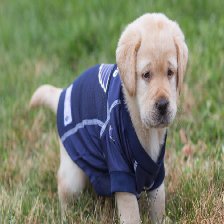

In [7]:
Five_image[0]

由于tuple中的对象是PIL,那么我们就可以使用```img.transpose(Image.FLIP_LEFT_RIGHT)```来将其水平翻转,最后统一转换成ndarray拼接到一个$(10\times 224\times 224\times 3)$的ndarray.

In [8]:
class Crop:

    def __init__(self, file_path):
        """
        Argus:
        -----
            file_path (string):   include testing data set files path.
        """
        self.file_path = file_path
        
    def __len__(self):
        return 10

    def __call__(self):
        """
        Return:
        ------
            Img: divide 255, and the shape is (batch,C x H x W)
        """
        image = Image.open(self.file_path)
        image = image.resize((256, 256))
        # get five pictures.
        five = transforms.FiveCrop(size=(224, 224))
        five_img = five(image)
        # transpose image of left and right.
        five_img_transpose = [np.array(img.transpose(Image.FLIP_LEFT_RIGHT)) for img in five_img]
        five_img = [np.array(img) for img in five_img]

        # stack two array. result shape (10,...)
        Img = np.vstack((five_img_transpose, five_img)) 
        Img = np.pad(Img, pad_width=((0, 0), (1, 2), (1, 2), (0, 0)), mode='constant')
        Img = np.divide(Img,255)
        
        Img = np.reshape(Img,(10,3,227,227))
        
        return Img

类```Crop```接受一个参数:```file_path```即测试样本的路径.

使用```Image```打开样本,并resize到$(256,256)$,使用```FiveCrop```提取5张图片,将其水平翻转后拼接数组得到$(10\times 224\times 224\times 3)$的ndarray.接着将图片pad到$(227\times 227)$再将图片reshape到Pytorch接受的形状即$(10\times 3\times 227\times 227)$

接下来我们来查看是否按照我们的要求生成测试样本.

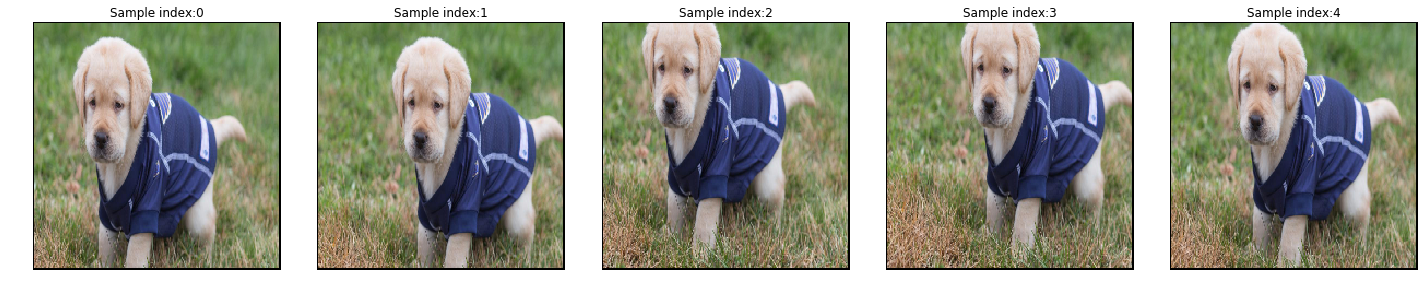

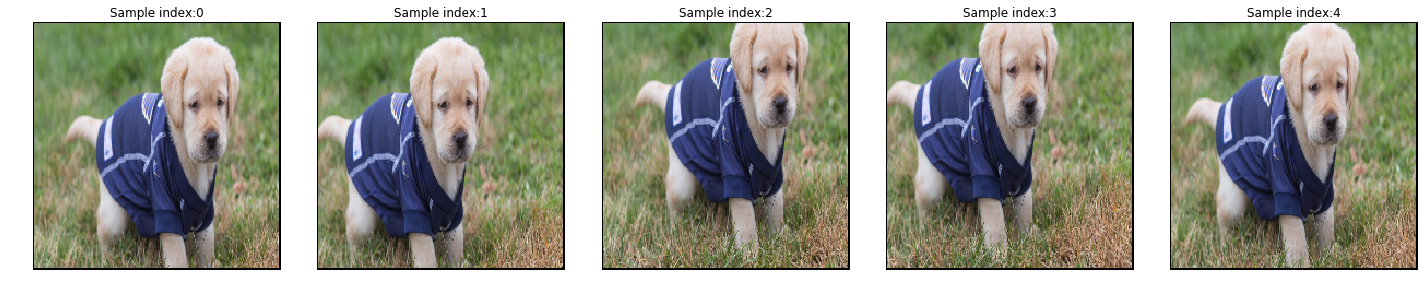

In [9]:
file_path = 'dog.jpg'
corp = Crop(file_path)
fig = plt.figure(figsize=(20,30))
images = corp()


for i in range(5):
    image = images[i]
    image = image.reshape((227,227,3))
    ax = plt.subplot(1,5,i+1)
    plt.tight_layout()
    ax.set_title('Sample index:{}'.format(i))
    ax.axis('off') # trun of axis
    plt.imshow(image)

fig = plt.figure(figsize=(20,30))
for i in range(5):
    image = images[i+5]
    image = image.reshape((227,227,3))
    ax = plt.subplot(1,5,i+1)
    plt.tight_layout()
    ax.set_title('Sample index:{}'.format(i))
    ax.axis('off') # trun of axis
    plt.imshow(image)
    
plt.show()

#### 4.2 Predict

现在我们已经能够将测试数据Crop成我们的目标结构,接下来我们就可以尝试预测.

In [14]:
def Predict(image_path):
    """
    Predict function
    
    Argu:
    ----
        image_path: predict image file path.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    corp = Crop(image_path)


    with torch.no_grad():
        model = Forward(rate=0)
        # load model. GPU training and CPU testing
        model.load_state_dict(torch.load('AlexNet_pytorch.pt', map_location=device))
        model.eval()
        
        img = corp()
        img = torch.FloatTensor(img)
        out = model.forward(img)
        predict = torch.round(out)
        dogs_rate = torch.mean(predict).item()
        cats_rate = 1 - dogs_rate
        print('Cats rate:{:.4f} %'.format(cats_rate*100))
        print('Dogs rate:{:.4f} %'.format(dogs_rate*100))

接下去我们使用```CatsVsDogs```数据集中test目录下的一张图片测试

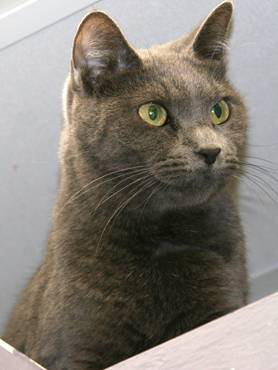

In [16]:
Cat_file = 'cat.jpg'
Cat_image = Image.open(Cat_file)
Cat_image

In [17]:
Predict(Cat_file)

Cats rate:70.0000 %
Dogs rate:30.0000 %


接着我们使用一张dog的图片测试.

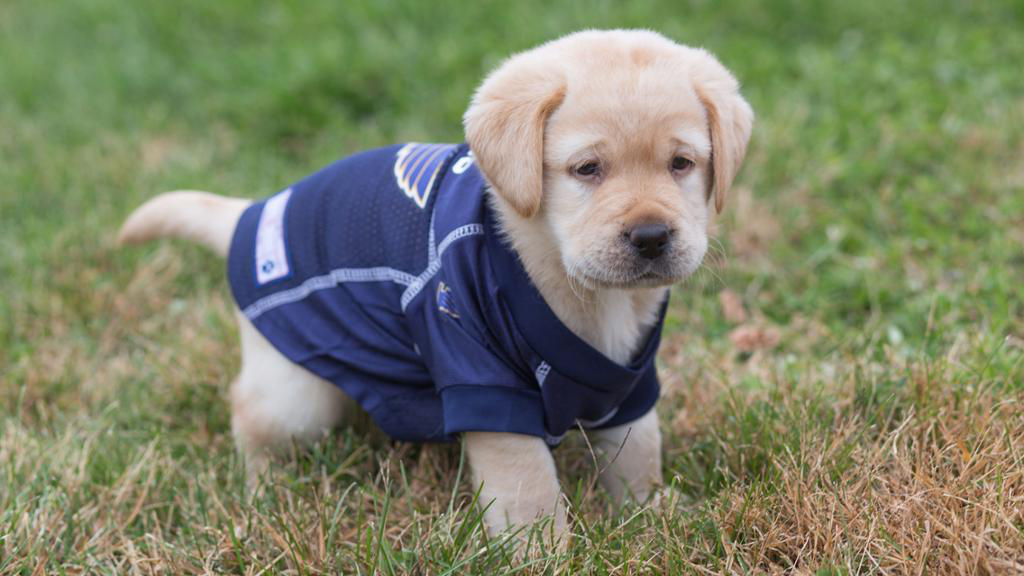

In [18]:
Dog_file = 'dog.jpg'
Dog_image = Image.open(Dog_file)
Dog_image

In [19]:
Predict(Dog_file)

Cats rate:0.0000 %
Dogs rate:100.0000 %
